In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
from collections.abc import Sequence
import windowCNV as wcnv
import seaborn as sns
import re
from scipy.sparse import issparse
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

In [ ]:
adata = sc.read_h5ad('SCP2745_high_conf_CAS_cell_types.h5ad') # Dataset from Single Cell Portal SCP2745
adata.obs['cell_type'] = adata.obs['high_conf_CAS_set_1_cell_types']

print(adata.obs.columns)

We first filter cells and genes to improve signal quality for downstream CNV inference.

In [ ]:
# 1. Annotate mitochondrial genes
# This assumes human data where mitochondrial genes start with "MT-"
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# 2. Compute quality control metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 3. Filter cells with <20% mitochondrial UMIs
adata = adata[adata.obs['pct_counts_mt'] < 20, :].copy()

# 4. Filter cells with at least 500 detected genes
sc.pp.filter_cells(adata, min_genes=500)

# 5. Filter cells with fewer than 30,000 total counts
sc.pp.filter_cells(adata, max_counts=30000)

# 6. Keep genes detected in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata , target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)

In [ ]:
adata

In [ ]:
print(adata.var.columns)


In [ ]:
def parse_gtf(gtf_file):
    # Read only gene-level lines
    rows = []
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            fields = line.strip().split('\t')
            if fields[2] != "gene":
                continue
            chrom, _, _, start, end, _, strand, _, info = fields

            info_dict = {}
            for item in info.strip().split(';'):
                if item.strip():
                    key, value = item.strip().split(' ')
                    info_dict[key] = value.strip('"')

            rows.append({
                "ensembl_id": info_dict.get("gene_id"),
                "gene_name": info_dict.get("gene_name"),
                "chromosome": chrom,
                "start": int(start),
                "end": int(end)
            })

    return pd.DataFrame(rows)

gtf_df = parse_gtf("gencode.v38.annotation.gtf")

In [ ]:
# Remove version numbers from GTF Ensembl IDs
gtf_df['ensembl_id_clean'] = gtf_df['ensembl_id'].str.replace(r'\.\d+$', '', regex=True)
# Remove version numbers from gene_ids
adata.var['gene_ids_clean'] = adata.var['gene_ids'].str.replace(r'\.\d+$', '', regex=True)
# Merge with cleaned Ensembl IDs from both sources
adata.var = adata.var.merge(
    gtf_df[['ensembl_id_clean', 'gene_name', 'chromosome', 'start', 'end']],
    left_on='gene_ids_clean',
    right_on='ensembl_id_clean',
    how='left'
)

# Rename gene_name to gene_symbol
adata.var.rename(columns={'gene_name': 'gene_symbol'}, inplace=True)

In [ ]:
print(adata.var[['gene_symbol', 'chromosome', 'start', 'end']].dropna().head())
print(adata.var['gene_ids_clean'].dropna().unique()[:5])
print(gtf_df['ensembl_id'].unique()[:5])

In [ ]:
adata.var['chromosome'] = adata.var['chromosome'].astype(str)
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: f'chr{x}' if not x.startswith('chr') else x)


In [ ]:
# PCA and clustering
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)


In [ ]:
adata.var_names = adata.var['gene_symbol']

In [ ]:
wcnv.find_reference_candidates(adata, "cell_type", 10)

We identify the lowest-variance cell types to select a reference population for CNV inference. The idea is that cells with minimal variation in their CNV signal are more likely to represent normal, diploid cells—those not affected by large-scale copy number alterations.

Using such stable reference cells helps ensure that the inferred CNVs in other cell types are biologically meaningful and not artifacts of technical noise or normalization bias. However, we avoid cell types with exactly zero variance because cell types with exactly zero variance, such as leukocytes or platelets, are likely underrepresented in the dataset, making them unreliable for normalization. Using such rare types may introduce noise due to poor genomic coverage. 

We chose "antibody secreting cell" as the reference because it has a low average variance, suggesting a stable CNV profile. For downstream evaluation, we will focus on "natural killer cell", a cell type with higher cell counts, to assess CNV inference performance in a more variable and well-represented population. This combination allows for both a reliable reference and a meaningful test population.

In [ ]:
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

wcnv.infercnv(
    adata,
    reference_key='cell_type',
    reference_cat='antibody secreting cell', 
    normalization_mode='reference',
    lfc_clip=3,
    window_distance=5e6,
    min_genes_per_window=5,
    smooth=True,
    dynamic_threshold=1.5,
    exclude_chromosomes=("chrX", "chrY"),
    chunksize=5000,
    n_jobs=4,
    inplace=True,
    layer='counts',
    key_added='cnv',
    calculate_gene_values=False
)


In [ ]:
X_cnv = adata.obsm['X_cnv'].copy()

print("Shape of X_cnv:", X_cnv.shape) 


In [ ]:
# Convert sparse matrix to dense
X_cnv = adata.obsm['X_cnv'].toarray()
cnv_df = pd.DataFrame(X_cnv, index=adata.obs_names)
chr_pos = adata.uns['cnv']['chr_pos']
sorted_chr_pos = sorted(chr_pos.items(), key=lambda x: x[1])

window_chromosomes = []
for i, (chrom, start_idx) in enumerate(sorted_chr_pos):
    end_idx = sorted_chr_pos[i + 1][1] if i + 1 < len(sorted_chr_pos) else X_cnv.shape[1]
    window_chromosomes.extend([chrom] * (end_idx - start_idx))

assert len(window_chromosomes) == cnv_df.shape[1]
cnv_df.columns = [f"{chrom}_bin{i}" for i, chrom in enumerate(window_chromosomes)]


Now we want to summarize the CNV burden which is the sum of absolute CNV signal per cell—across different cell types. By visualizing the distribution of CNV burden per cell type, we can identify which cell populations exhibit greater variability in copy number alterations.

In [ ]:
# Sum of absolute CNV signal per cell
adata.obs["cnv_burden"] = cnv_df.abs().sum(axis=1)

# Boxplot grouped by cell type
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=adata.obs, x="cell_type", y="cnv_burden")
plt.xticks(rotation=45, ha='right')
plt.title("CNV Burden Across Cell Types")
plt.tight_layout()
plt.show()


Most cell types exhibit low to moderate CNV burden, with relatively tight distributions. However, some cell types, such as natural killer cells, non-classical monocytes, and myeloid leukocytes, show noticeably higher CNV burden, both in median values and variability. These elevated levels may suggest greater genomic instability or could result from artifacts in inference (expression noise or normalization bias). Conversely, cell types like platelets, plasmacytoid dendritic cells, and leukocytes show minimal CNV burden, indicating stability or possibly low expression complexity. 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA for dimensionality reduction
pca = PCA(n_components=10)
cnv_pca = pca.fit_transform(cnv_df)

# Cluster cells using KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
adata.obs["cnv_cluster"] = kmeans.fit_predict(cnv_pca).astype(str)

# Visualize clusters on UMAP
import scanpy as sc
sc.pl.umap(adata, color=["cnv_cluster", "cell_type"])


In [ ]:
wcnv.assign_cnas_to_cells_parallel(adata, gain_percentile=60, loss_percentile=60)
wcnv.plot_inferred_cnv_map(adata, cell_type="antibody secreting cell")

In [23]:
def format_called_cnas(cna_list):
    if not cna_list or not isinstance(cna_list, list):
        return ""
    formatted = []
    for chrom, start, end, event in cna_list:
        cn = "3" if event == "gain" else "1"
        formatted.append(f"{chrom.replace('chr', '')}:{start}-{end} (CN {cn})")
    return "; ".join(formatted)

# Apply to create the new column
adata.obs["simulated_cnvs"] = adata.obs["called_cnas"].apply(format_called_cnas)

Now we apply the evaluate_cnv_with_window function, which focuses on the most confident CNV events by using percentile-based thresholds. Rather than analyzing all events—including potentially noisy or weak signals—it highlights well-supported matches between inferred and ground truth CNVs. The function also accounts for unevaluable events and summarizes top-performing results in a heatmap using precision, recall, F1, and accuracy, making the evaluation clearer and prioritizing reliable CNV calls.

In [25]:
def evaluate_cnv_with_window(
    adata,
    celltype_key='cell_type',
    cnv_truth_key='simulated_cnvs',
    cnv_inferred_key='cnv',
    gain_percentile=90,
    loss_percentile=10
):
    inferred = adata.obsm[f"X_{cnv_inferred_key}"]
    if issparse(inferred):
        inferred = inferred.toarray()

    # --- Percentile-based thresholds ---
    flat_vals = inferred.flatten()
    pos_vals = flat_vals[flat_vals > 0]
    neg_vals = flat_vals[flat_vals < 0]
    
    if len(pos_vals) > 0:
        gain_threshold = np.percentile(pos_vals, 100 - gain_percentile)
    else:
        gain_threshold = np.inf  # Effectively disables gain detection
    
    if len(neg_vals) > 0:
        loss_threshold = np.percentile(neg_vals, loss_percentile)
    else:
        loss_threshold = -np.inf  # Effectively disables loss detection
    
    print(f"[INFO] Gain threshold: > {gain_threshold:.4f}")
    print(f"[INFO] Loss threshold: < {loss_threshold:.4f}")

    chr_pos_dict = dict(sorted(adata.uns[cnv_inferred_key]["chr_pos"].items(), key=lambda x: x[1]))
    window_index_map = []
    chr_keys = list(chr_pos_dict.keys())
    chr_vals = list(chr_pos_dict.values())
    for i, chrom in enumerate(chr_keys):
        start = chr_vals[i]
        end = chr_vals[i + 1] if i + 1 < len(chr_vals) else inferred.shape[1]
        for j in range(start, end):
            window_index_map.append((chrom, j))
    window_df = pd.DataFrame(window_index_map, columns=["chromosome", "matrix_idx"])

    pattern = r"(\w+):(\d+)-(\d+)\s+\(CN\s+(\d)\)"
    grouped_results = {}
    unmatched_fp_keys = set()
    excluded_event_keys = set()
    printed_exclusions = set()

    gt_event_set = set()
    for idx, row in adata.obs.iterrows():
        ct = row[celltype_key]
        annots = row.get(cnv_truth_key, "")
        row_idx = adata.obs_names.get_loc(idx)
        if isinstance(annots, str) and annots.strip() != "":
            matches = re.findall(pattern, annots)
            for chrom, start, end, cn in matches:
                chrom = f"chr{chrom}" if not chrom.startswith("chr") else chrom
                cn = int(cn)
                if cn == 2:
                    continue
                gt = "gain" if cn > 2 else "loss"
                gt_event_set.add((ct, chrom, cn, gt))

    for idx, row in adata.obs.iterrows():
        ct = row[celltype_key]
        annots = row.get(cnv_truth_key, "")
        row_idx = adata.obs_names.get_loc(idx)

        if isinstance(annots, str) and annots.strip() != "":
            matches = re.findall(pattern, annots)
            for chrom, start, end, cn in matches:
                chrom = f"chr{chrom}" if not chrom.startswith("chr") else chrom
                cn = int(cn)
                if cn == 2:
                    continue
                gt = "gain" if cn > 2 else "loss"
                win_idxs = window_df[window_df["chromosome"] == chrom]["matrix_idx"].values
                key = (ct, chrom, cn, gt)
                if len(win_idxs) == 0:
                    if key not in printed_exclusions:
                        print(f"Excluded GT CNV event due to missing chromosome: {key}")
                        printed_exclusions.add(key)
                    excluded_event_keys.add(key)
                    continue
                win_vals = inferred[row_idx, win_idxs]
                max_val = win_vals.max()
                min_val = win_vals.min()
                pred = "gain" if max_val > gain_threshold else (
                    "loss" if min_val < loss_threshold else "no_change"
                )
                pred_label = int(pred == gt)
                if key not in grouped_results:
                    grouped_results[key] = {"true": [], "pred": []}
                grouped_results[key]["true"].append(1)
                grouped_results[key]["pred"].append(pred_label)

        for chrom in window_df["chromosome"].unique():
            win_idxs = window_df[window_df["chromosome"] == chrom]["matrix_idx"].values
            if len(win_idxs) == 0:
                continue
            win_vals = inferred[row_idx, win_idxs]
            max_val = win_vals.max()
            min_val = win_vals.min()
            pred = "gain" if max_val > gain_threshold else (
                "loss" if min_val < loss_threshold else "no_change"
            )
            if pred == "no_change":
                continue
            for ct_gt, chr_gt, cn_gt, gt_label in gt_event_set:
                if ct_gt == ct and gt_label == pred and chr_gt == chrom:
                    key = (ct, chr_gt, cn_gt, gt_label)
                    if key not in excluded_event_keys:
                        if key not in grouped_results:
                            grouped_results[key] = {"true": [], "pred": []}
                        grouped_results[key]["true"].append(0)
                        grouped_results[key]["pred"].append(1)

    # Build final dataframe
    metrics_rows = []
    all_keys = gt_event_set.union(excluded_event_keys)
    for key in sorted(all_keys):
        ct, chrom, cn, gt = key
        if key in excluded_event_keys:
            metrics_rows.append({
                "cell_type": ct, "chromosome": chrom, "CN": cn, "groundtruth": gt,
                "TP": None, "FP": None, "FN": None,
                "precision": None, "recall": None, "f1": None,
                "accuracy": None, "n_events": 0
            })
        else:
            y_true = grouped_results[key]["true"]
            y_pred = grouped_results[key]["pred"]
            TP = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
            FP = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1)
            FN = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 0)
            metrics_rows.append({
                "cell_type": ct, "chromosome": chrom, "CN": cn, "groundtruth": gt,
                "TP": TP, "FP": FP, "FN": FN,
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
                "f1": f1_score(y_true, y_pred, zero_division=0),
                "accuracy": accuracy_score(y_true, y_pred),
                "n_events": len(y_true)
            })

    df = pd.DataFrame(metrics_rows)
    df["CN"] = df["CN"].astype(str)
    n_predicted = sum([sum(x['pred']) for x in grouped_results.values()])

    df_best = df.dropna().sort_values(by="f1", ascending=False)
    df_top = df_best[df_best["f1"] > 0.9]  # ← Adjusted threshold 

    heatmap_df = df_top.set_index(["cell_type", "chromosome", "CN", "groundtruth"])[
        ["precision", "recall", "f1", "accuracy"]
    ]
    heatmap_df.index = heatmap_df.index.map(lambda x: f"{x[0]}_{x[1]}_CN{x[2]}_{x[3]}")
    heatmap_df.index.name = "CNV Event"

    plt.figure(figsize=(10, 1 * len(heatmap_df)))
    sns.heatmap(
        heatmap_df, annot=True, fmt=".4f",
        cmap=sns.light_palette("red", as_cmap=True),
        linewidths=0.5, linecolor="black",
        mask=heatmap_df.isnull(), cbar_kws={'label': 'Score'},
        vmin=0.0, vmax=1.0
    )
    plt.title("Top CNV Inference Metrics (Filtered)")
    plt.tight_layout()
    plt.show()

    print(f"[INFO] Total predicted CNVs: {n_predicted}")
    print(f"[INFO] CNVs plotted (f1 > 0.9): {len(df_top)}")

    return df_top, excluded_event_keys


[INFO] Gain threshold: > 0.2611
[INFO] Loss threshold: < -0.2108


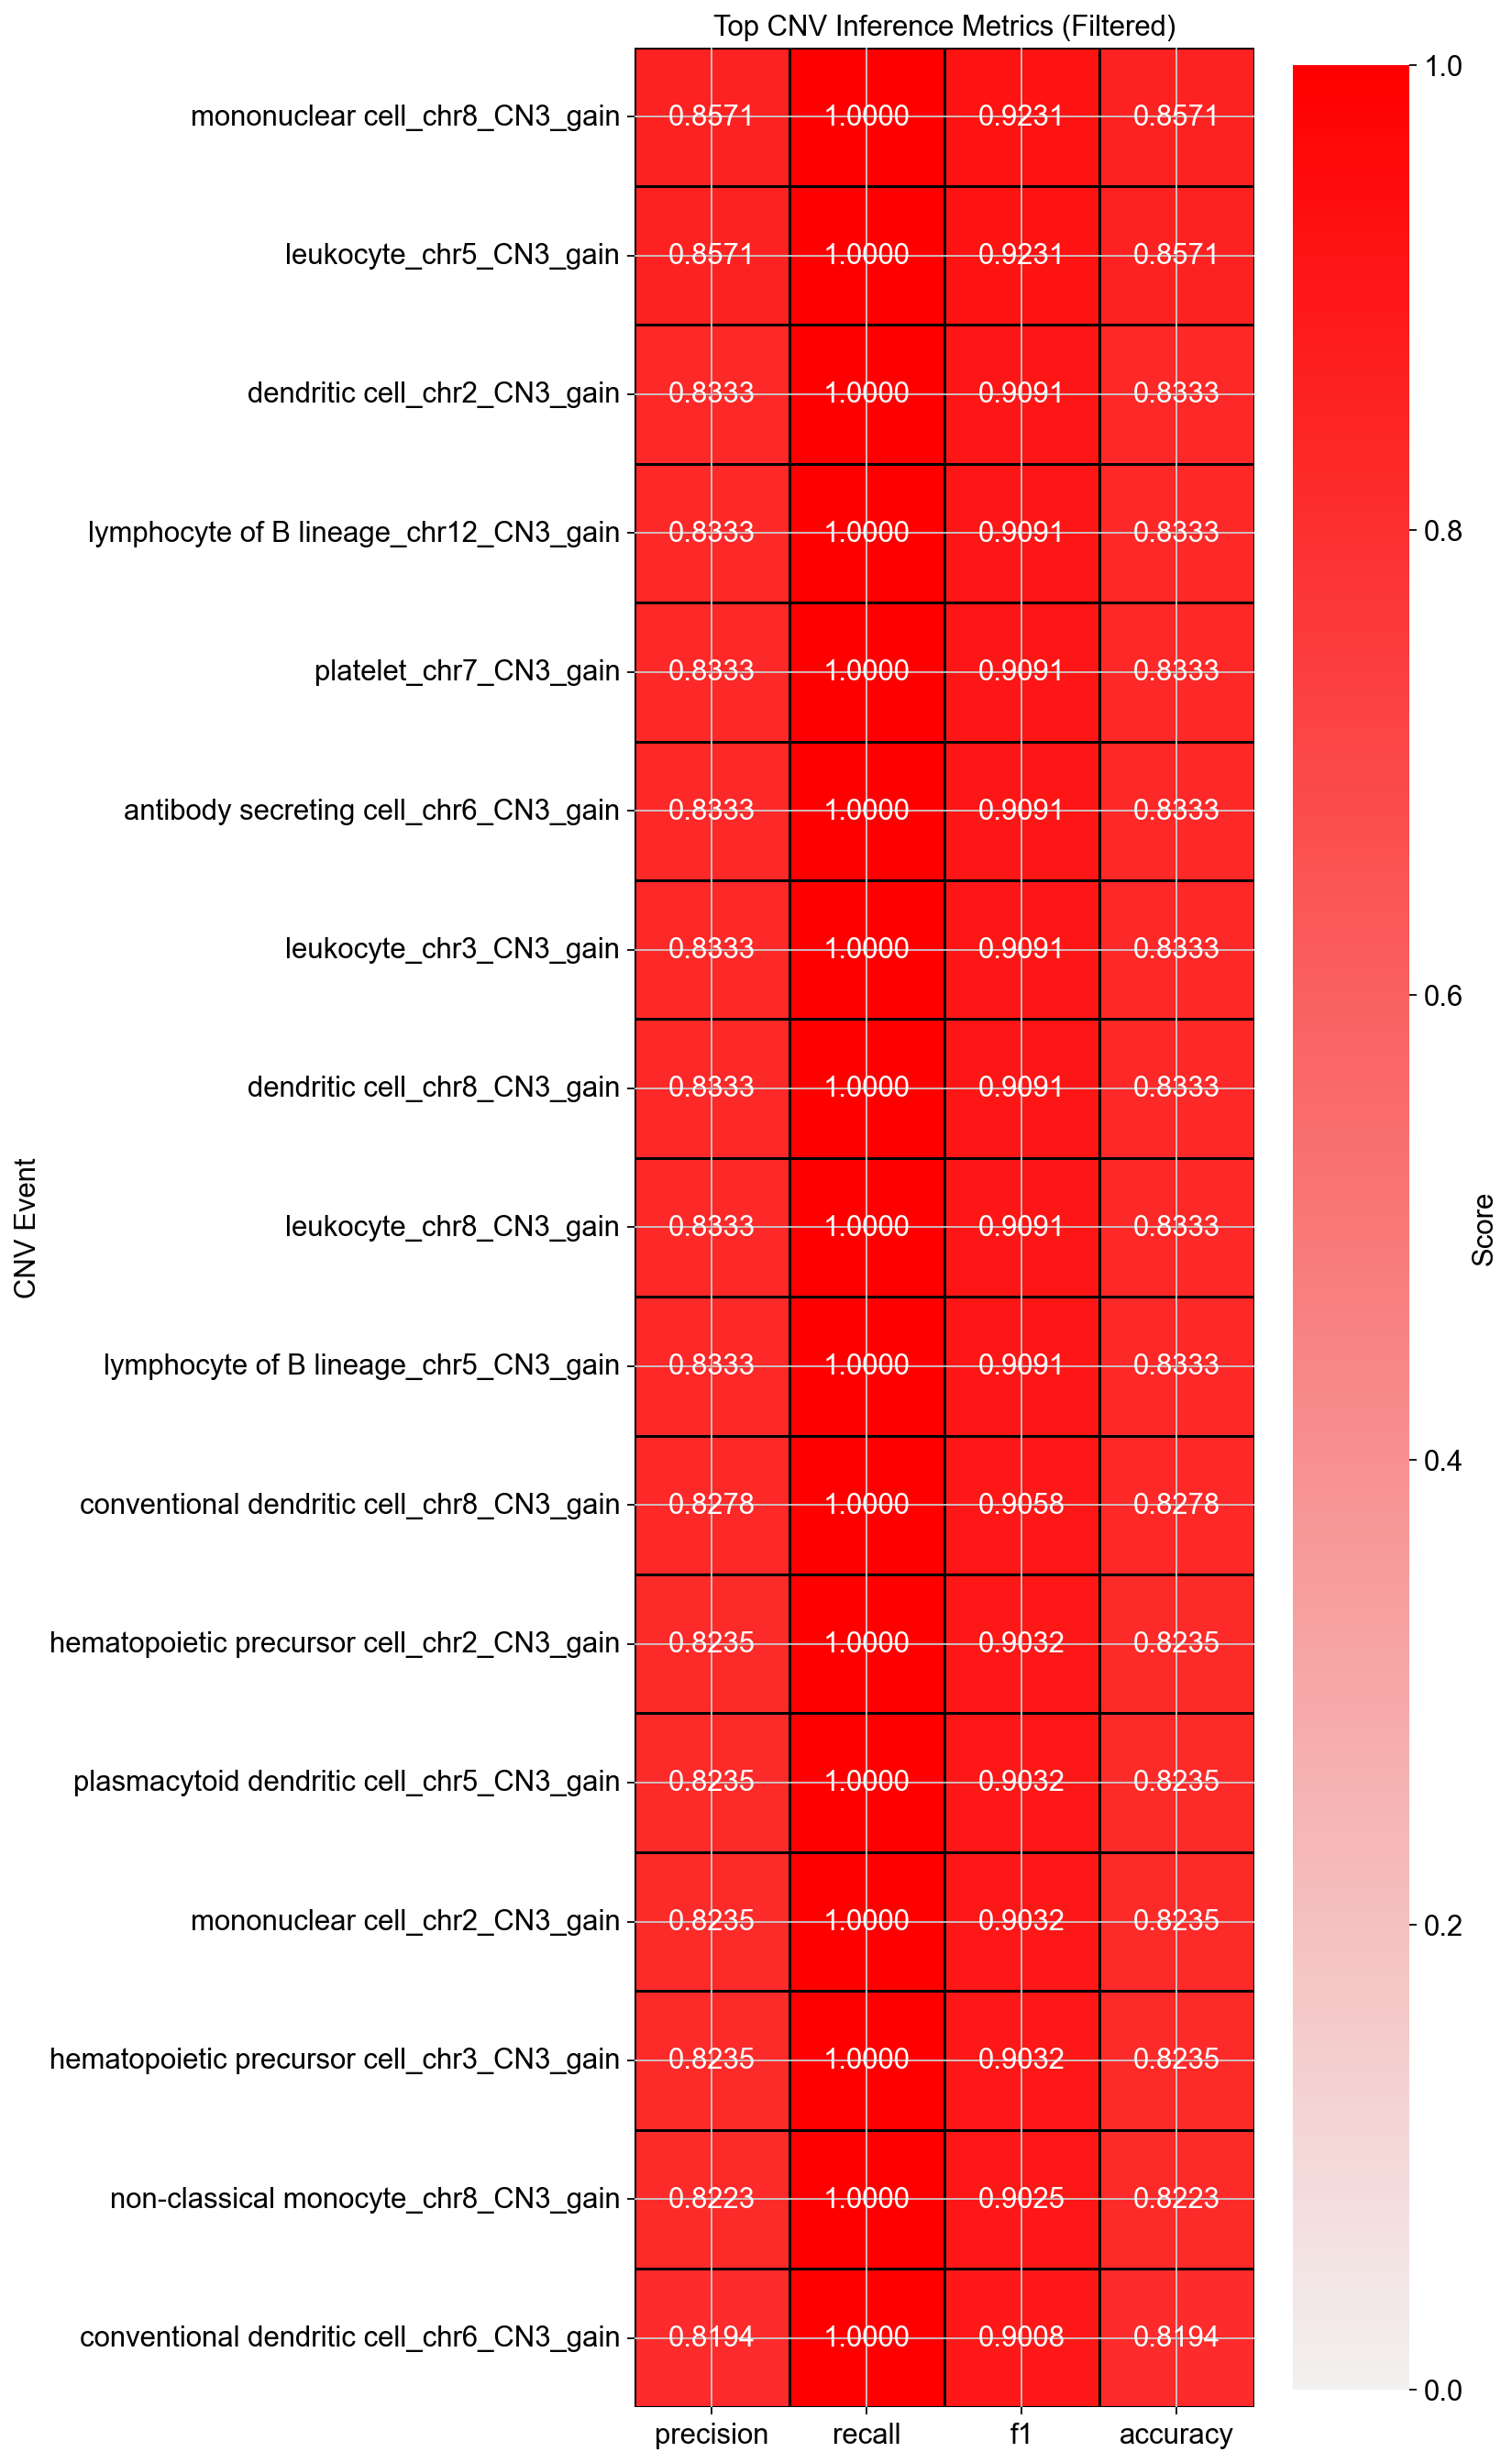

[INFO] Total predicted CNVs: 133930
[INFO] CNVs plotted (f1 > 0.9): 17


In [26]:
df_top, excluded = evaluate_cnv_with_window(
    adata,
    gain_percentile=40,
    loss_percentile=50
)

This heatmap shows the top CNV inference events filtered by F1 score, where only those with F1 > 0.9 are plotted. The metrics—precision, recall, F1, and accuracy—are nearly perfect for these events, indicating very reliable detection of copy number gains, particularly on chromosomes 2, 3, 5, 6, 7, 8, and 12 across several immune-related cell types like dendritic cells, leukocytes, and natural killer cells.

In [28]:
def fix_simulated_cnvs_format_for_plotting(adata, source_key="simulated_cnvs", target_key="simulated_cnvs_parsed"):
    cleaned_cnvs_strs = []

    for s in adata.obs[source_key]:
        if pd.isna(s) or str(s).strip() == "":
            cleaned_cnvs_strs.append("")
            continue

        matches = re.findall(r"(\d+):(\d+)-(\d+)\s*\(CN\s*(\d+)\)", s)
        formatted = [f"chr{chrom}:{start}-{end} (CN {cn})" for chrom, start, end, cn in matches]
        cleaned_cnvs_strs.append(", ".join(formatted))

    adata.obs[target_key] = cleaned_cnvs_strs

In [29]:
fix_simulated_cnvs_format_for_plotting(adata)

Now we apply the function plot_cnv_groundtruth_vs_inferred, which compares inferred CNVs to ground truth CNVs specifically for "antibody secreting cell" and "natural killer cell". We use the cleaned annotations (simulated_cnvs_parsed) as the reference and compare them to the inferred values (cnv). This helps us visually evaluate how well our CNV detection works for these cell types.

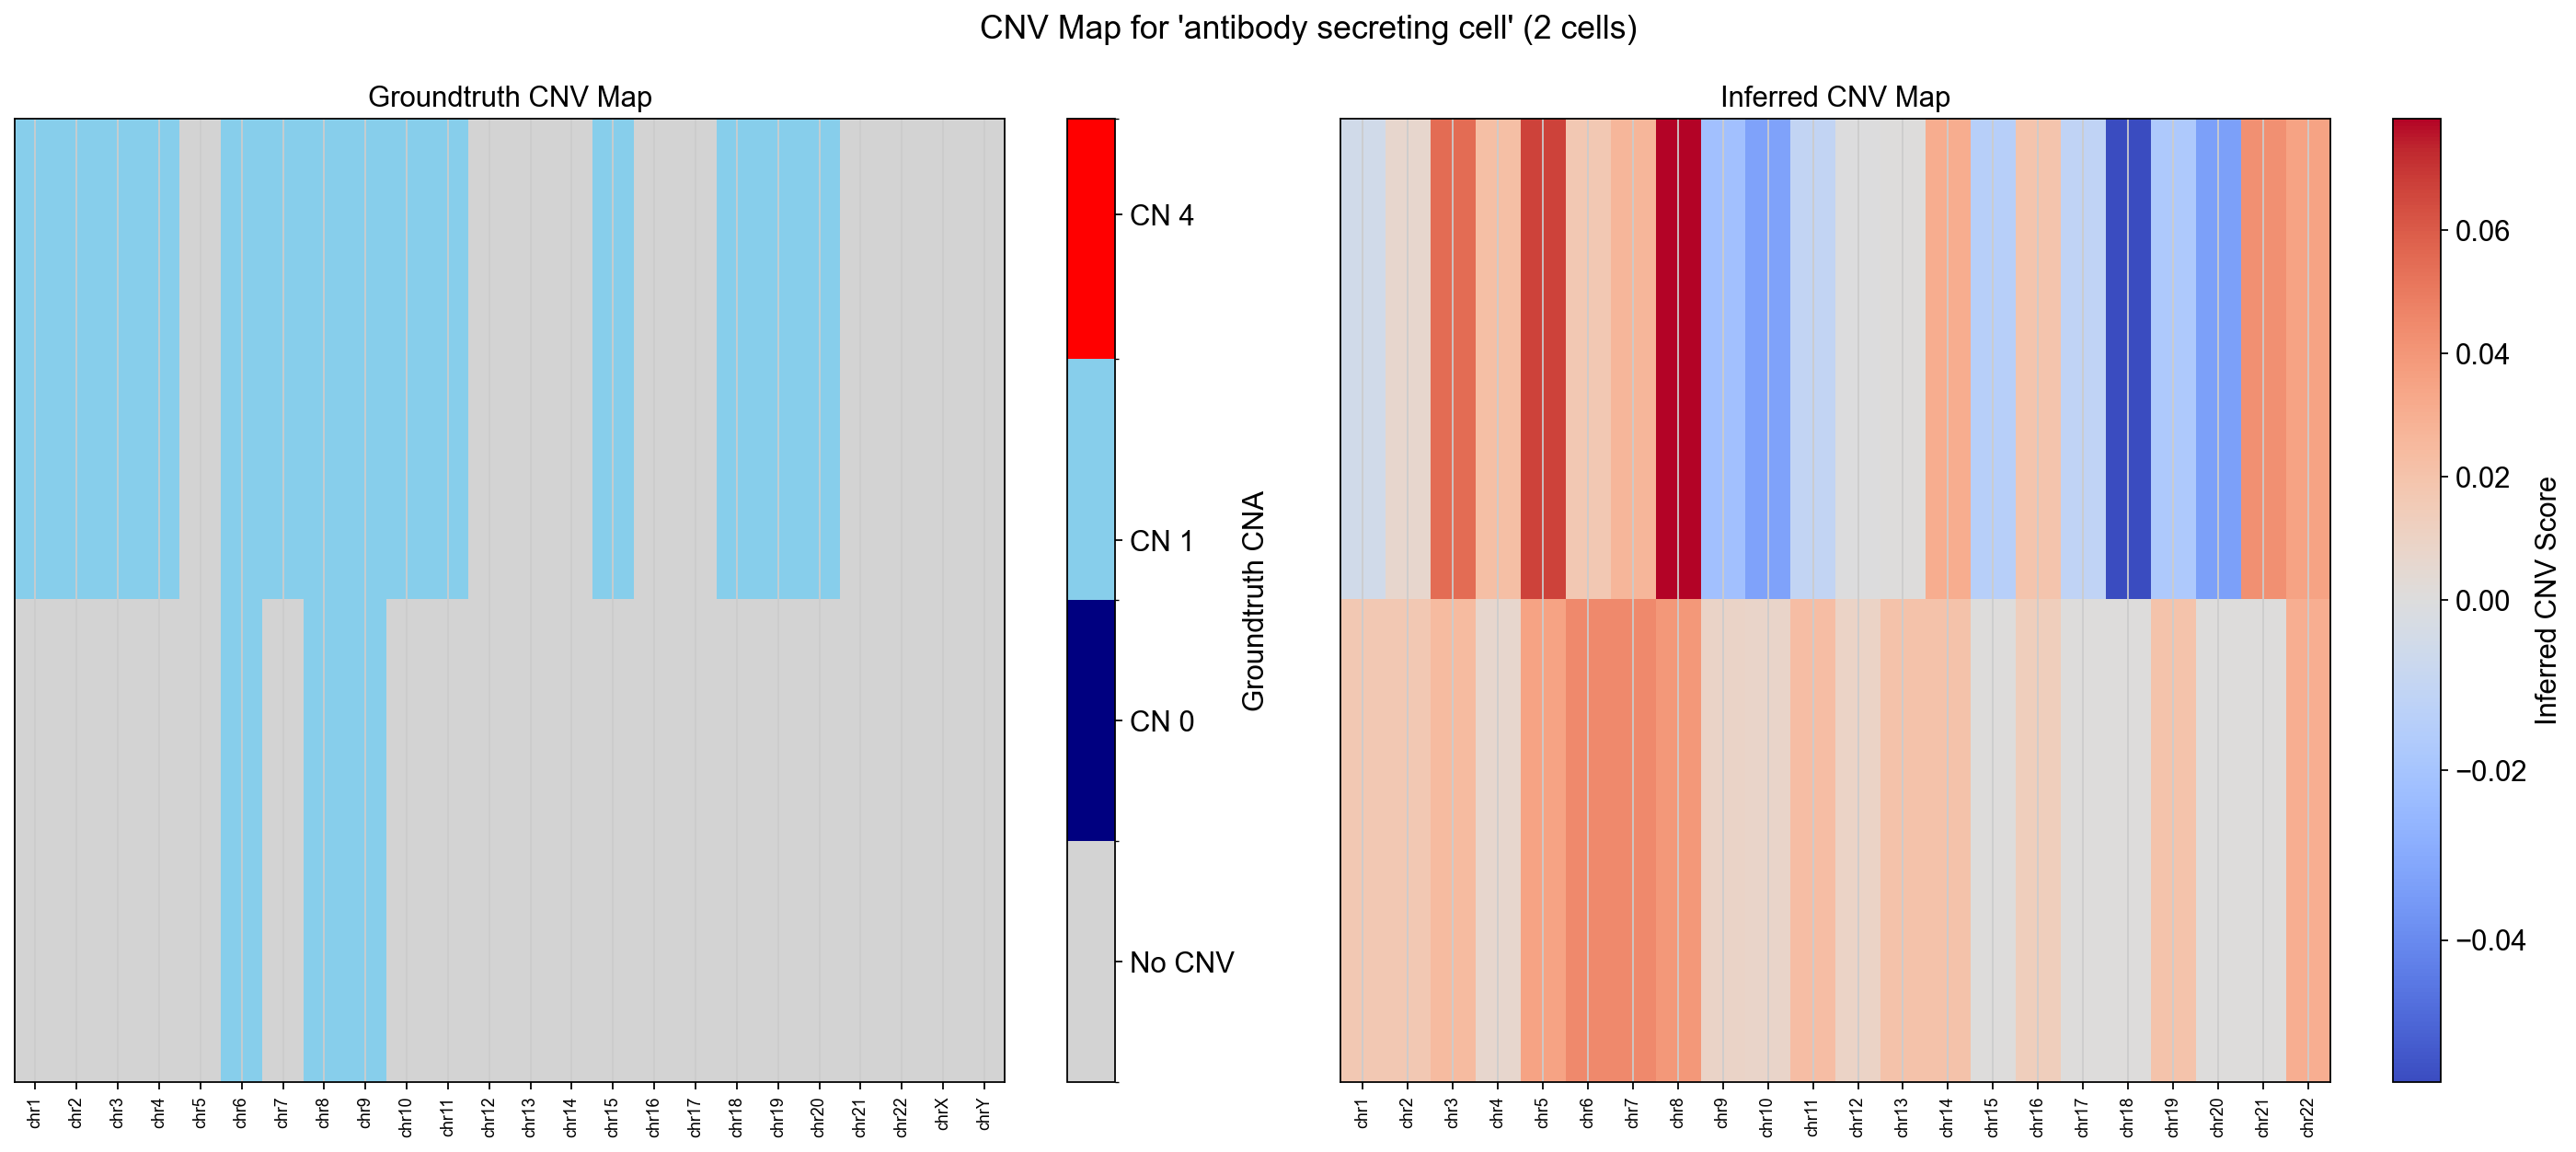

In [31]:
wcnv.plot_cnv_groundtruth_vs_inferred(
    adata,
    cell_type='antibody secreting cell',
    cnv_truth_key='simulated_cnvs_parsed',  # cleaned 
    cnv_inferred_key='cnv'
)

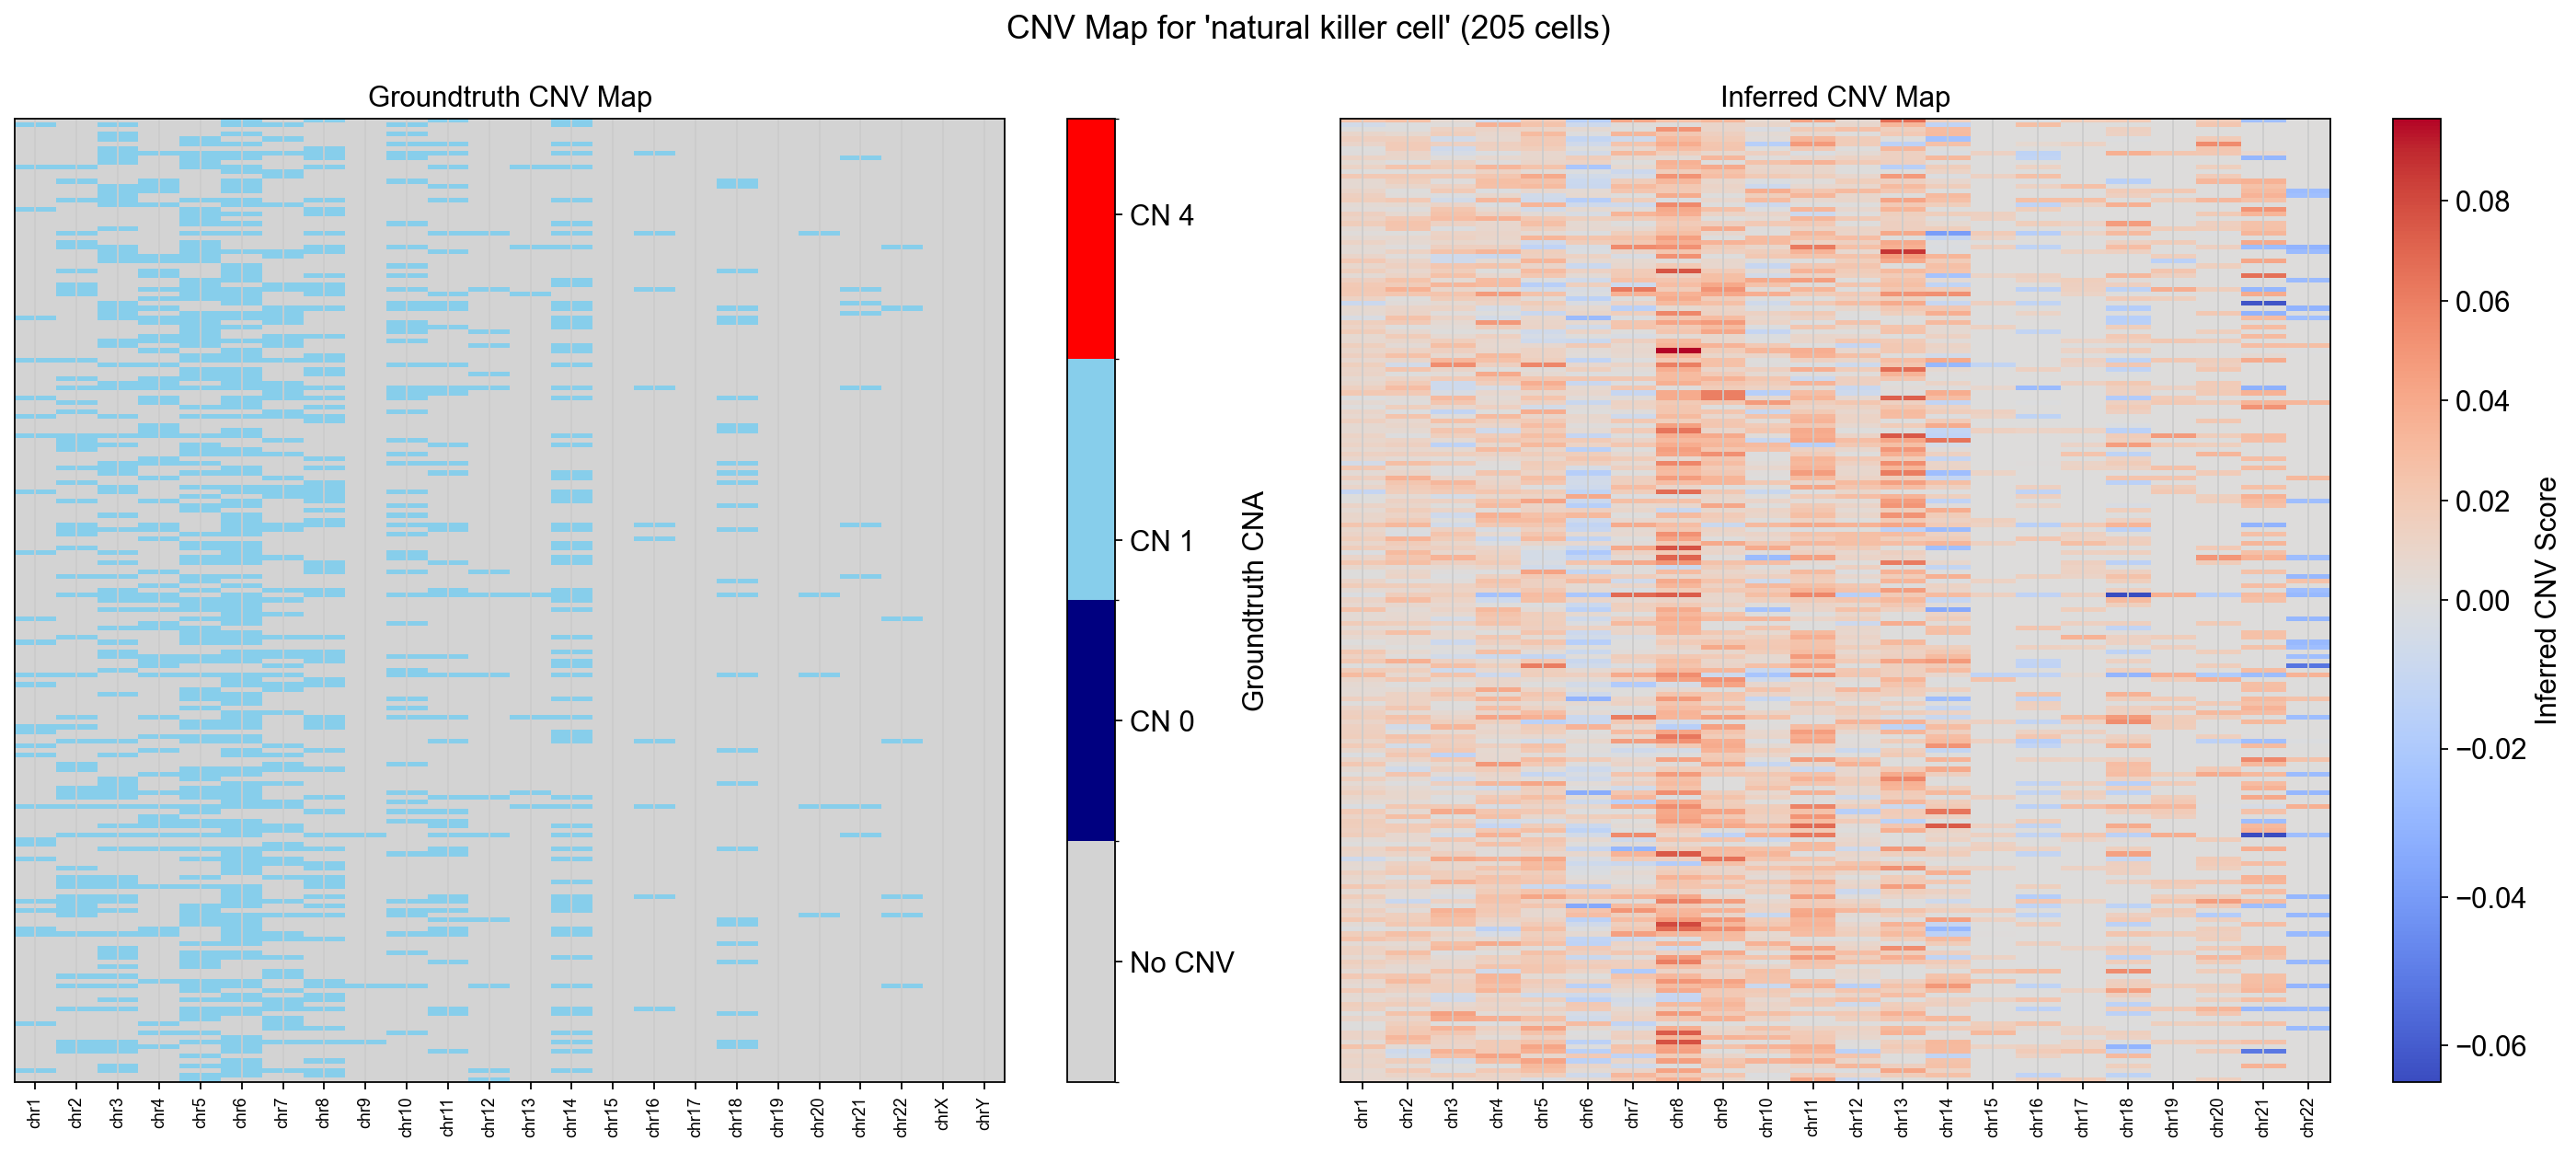

In [32]:
wcnv.plot_cnv_groundtruth_vs_inferred(
    adata,
    cell_type='natural killer cell',
    cnv_truth_key='simulated_cnvs_parsed',  # cleaned 
    cnv_inferred_key='cnv'
)

In antibody secreting cells, the small number of samples results in a relatively weak signal and a noisier inferred CNV profile, with less consistent alignment to the ground truth events. Despite this, some deletions (on chr4, chr9, chr13) are captured. In contrast, the natural killer cell group, due to its larger cell count, yields a much cleaner and structured inferred CNV map. The CNV scores show more consistent signal across cells and chromosomes, indicating that higher cell counts significantly improve the robustness and detectability of CNVs. Notably, the inferred signal for natural killer cells captures a wider range of CNV scores but also introduces potential overcalling in regions without strong ground truth support (scattered gains across chr1 and chr5). Overall, this comparison emphasizes the importance of cell count in CNV inference quality and suggests a trade-off between signal clarity and the risk of overprediction.

Now we apply the function plot_groundtruth_and_inferred_cnv, which visualizes both the ground truth and inferred CNV profiles for the "antibody secreting cell" and "natural killer cell". Using the cleaned annotations in simulated_cnvs_parsed, this plot allows us to directly compare the overall CNV landscape between the expected and detected signals in a single view.

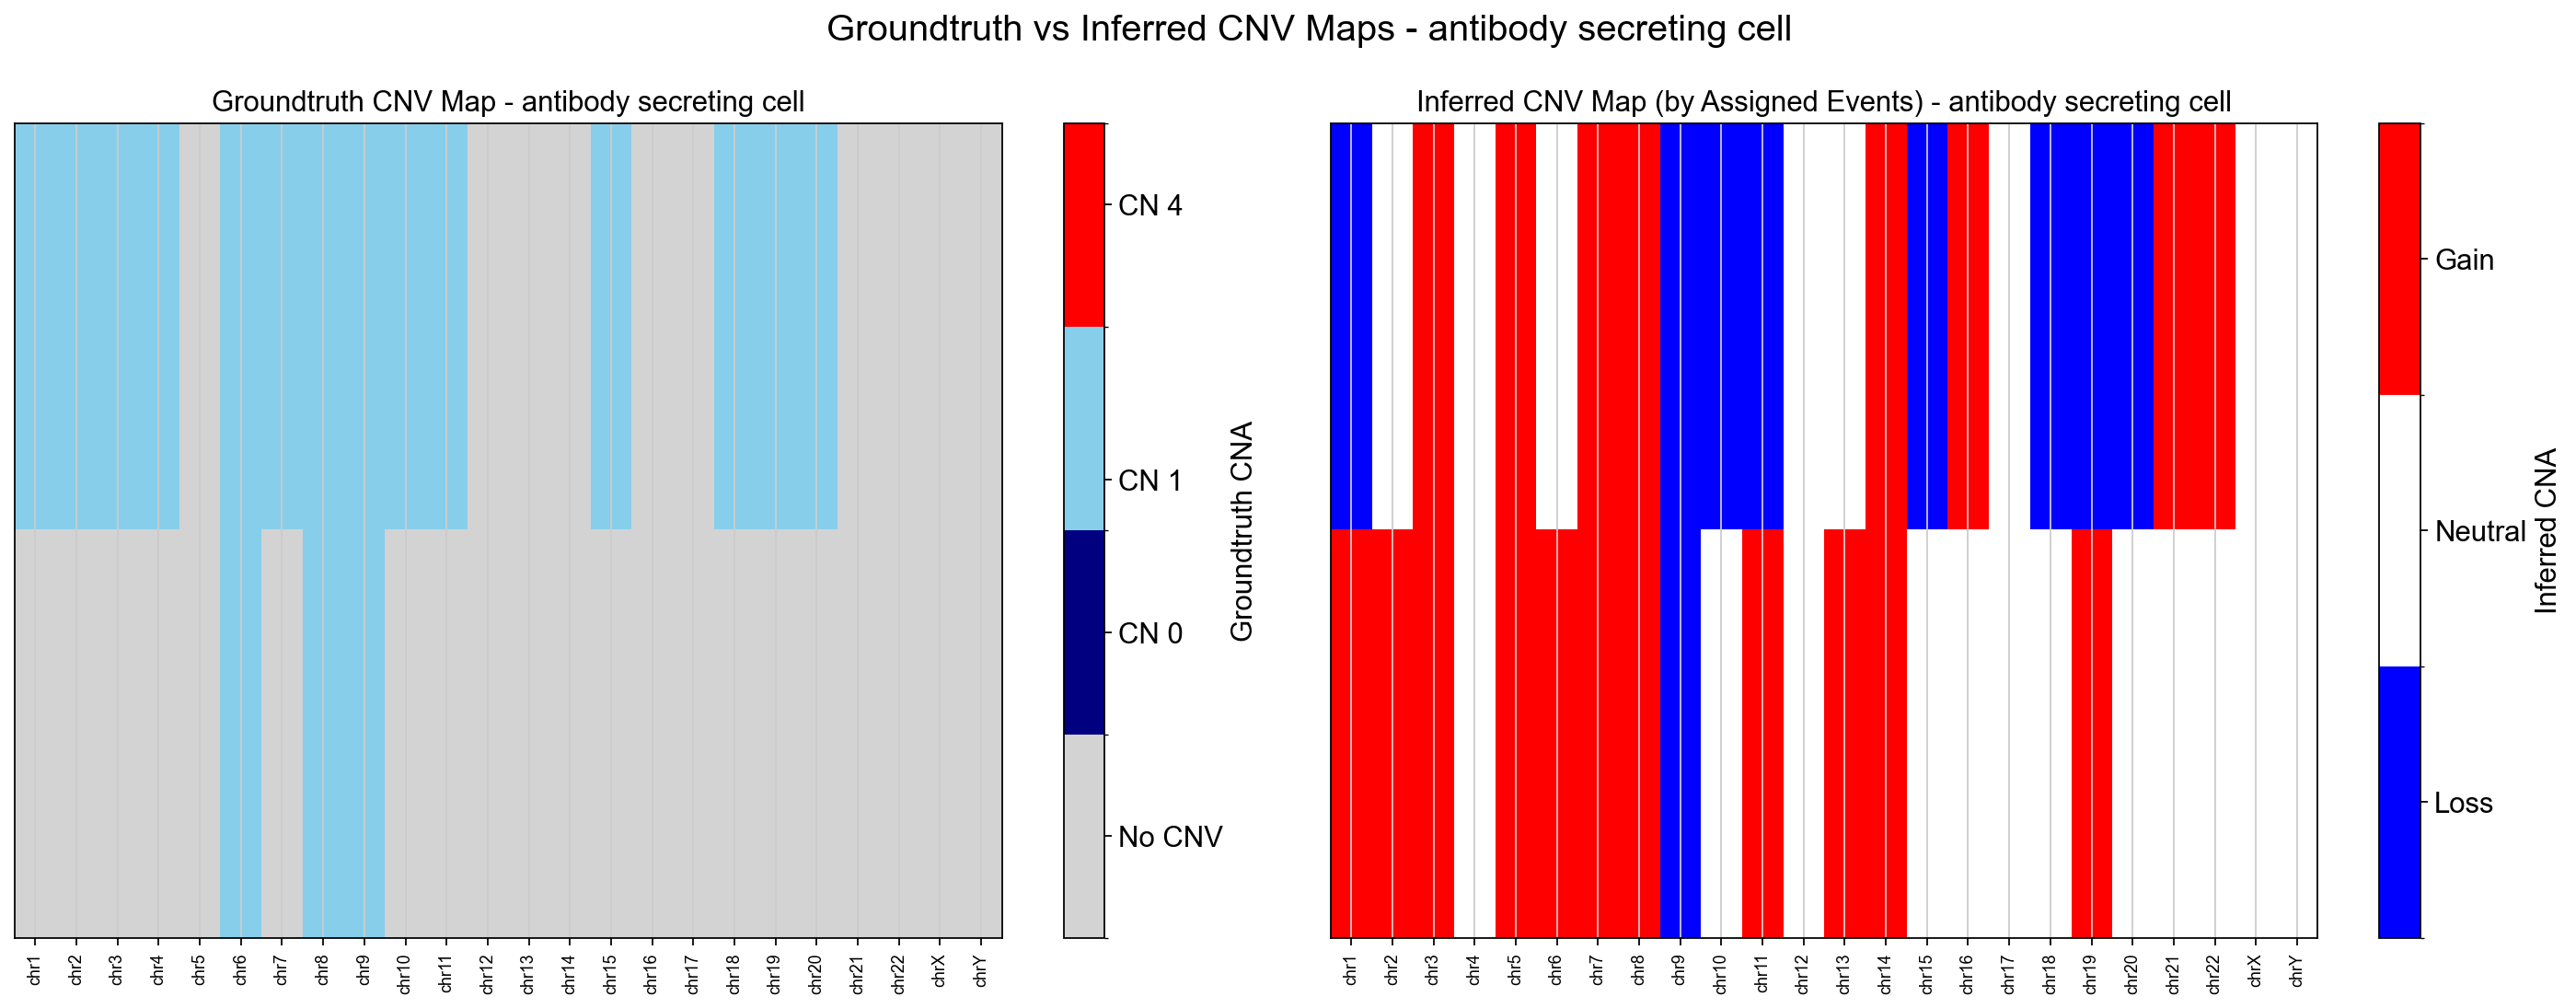

In [37]:
wcnv.plot_groundtruth_and_inferred_cnv(adata, cell_type='antibody secreting cell',
    cnv_truth_key='simulated_cnvs_parsed')

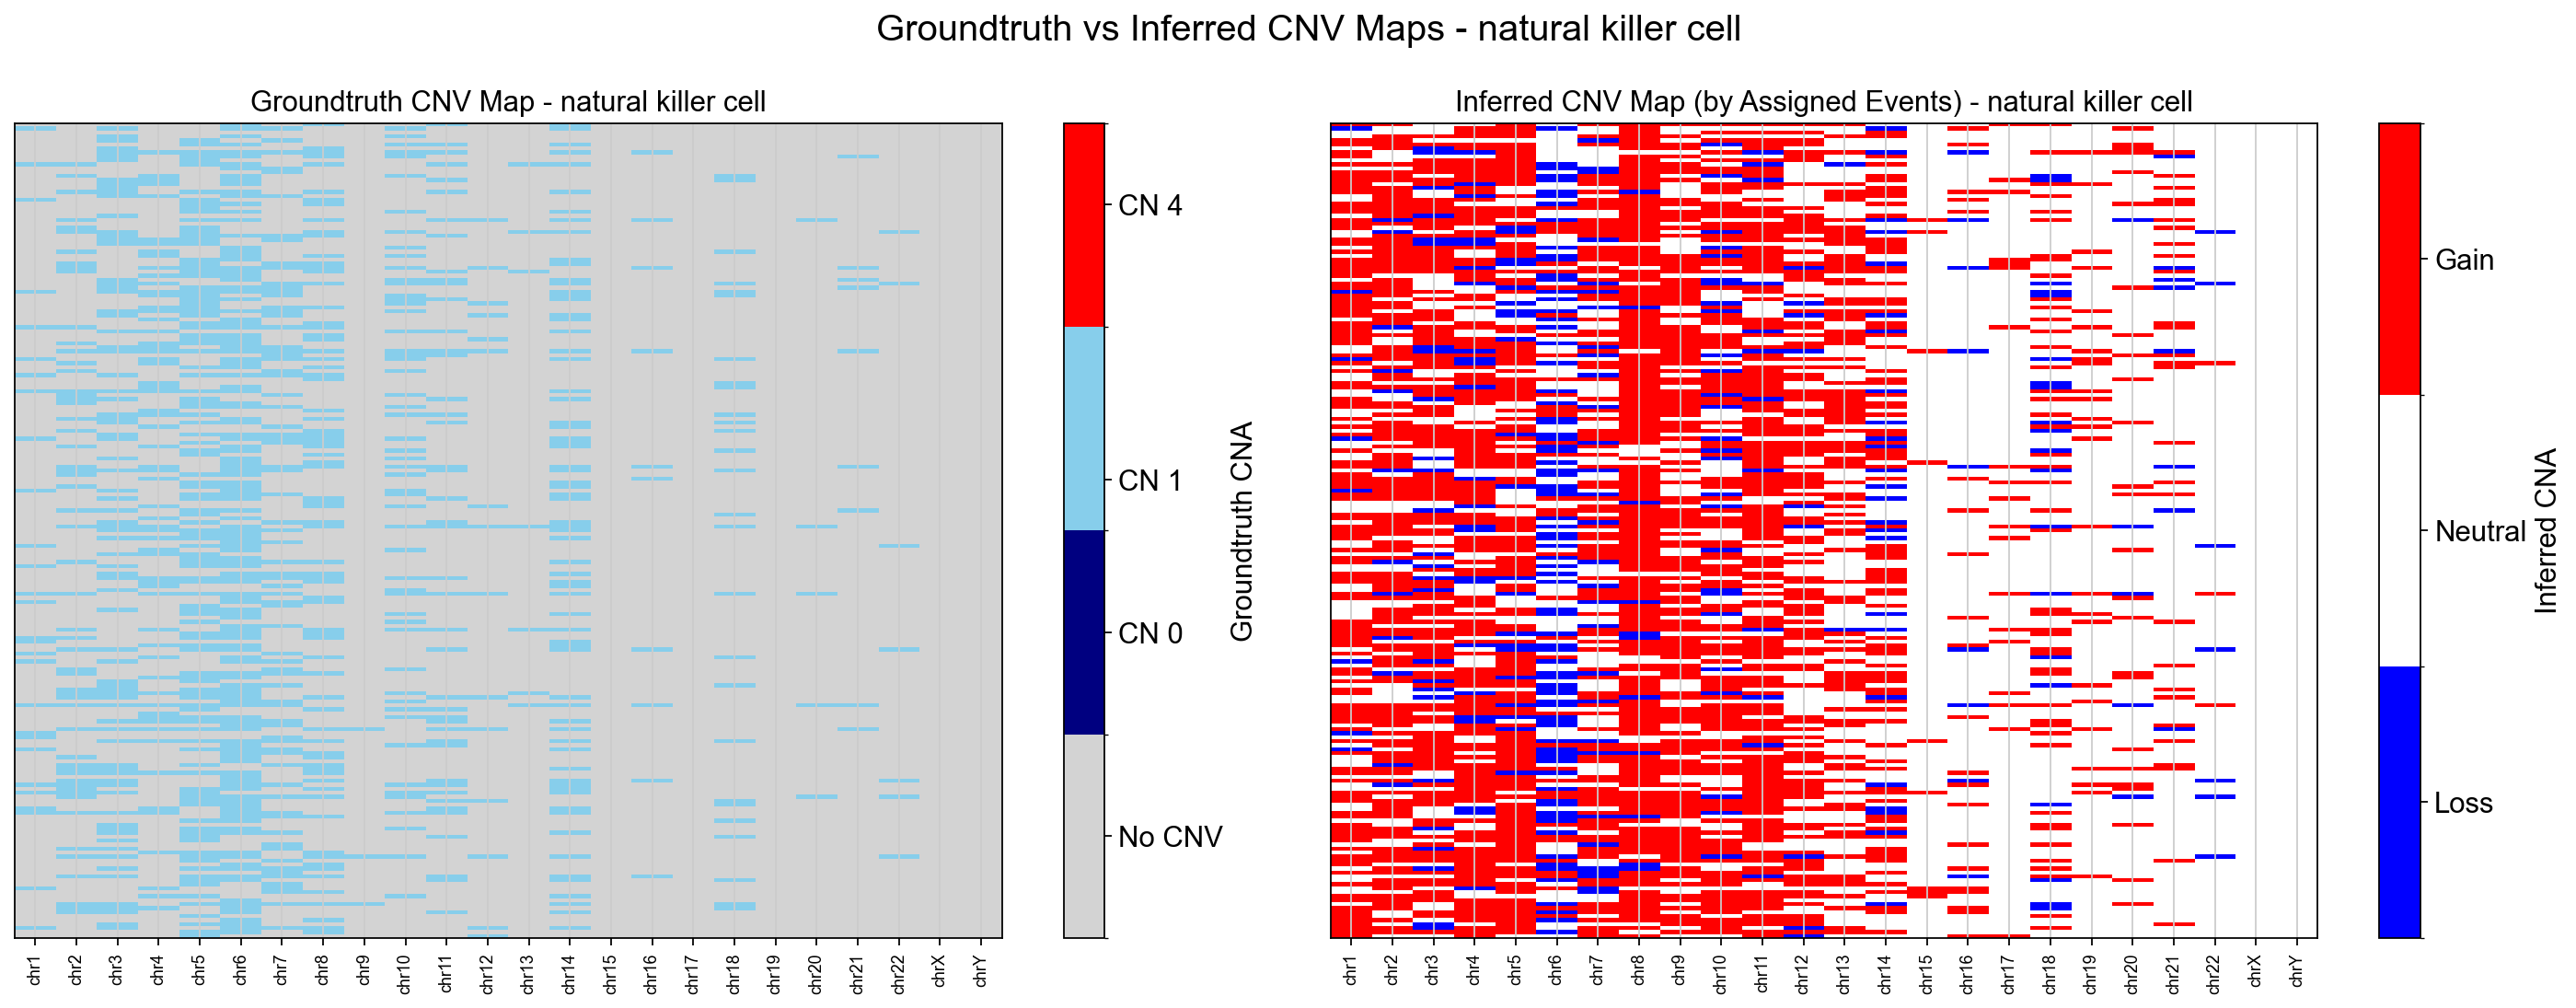

In [38]:
wcnv.plot_groundtruth_and_inferred_cnv(adata, cell_type='natural killer cell',
    cnv_truth_key='simulated_cnvs_parsed')

In the antibody secreting cell group (only 2 cells), the inferred CNVs align well with the ground truth deletions (on chr4, chr9, chr13), showing strong agreement and minimal noise. However, due to the extremely low cell count, the robustness of these patterns is limited and potentially unreliable for generalization. In contrast, natural killer cells (n = 205) show a more comprehensive and biologically variable CNV landscape. While this improves statistical reliability, it also introduces extensive overcalling. The inferred CNV map displays frequent gains and losses not present in the ground truth, especially on chromosomes chr1, chr5, and chr6, suggesting false positives driven by noise or model over-sensitivity. This comparison highlights the trade-off between signal clarity and reliability: small cell groups may yield cleaner signals but lack statistical strength, while large groups increase power but risk inflating spurious CNV calls.